### Assignment 1

Jeffin Biju (EE19B085) and Rajdeep Paul (EE19B109)

In [ ]:
# Run this only if you are using Google Colab
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)

# change path here as per your directory structure
os.chdir('drive/My Drive/CS6700/assignment_1')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install relevant libraries
!pip install numpy matplotlib tqdm scipy

### Importing the environment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from PA1 import GridWorld, seq_to_col_row
%matplotlib inline

In [ ]:
DOWN = 0
UP = 1
LEFT = 2
RIGHT = 3
actions = [DOWN, UP, LEFT, RIGHT]

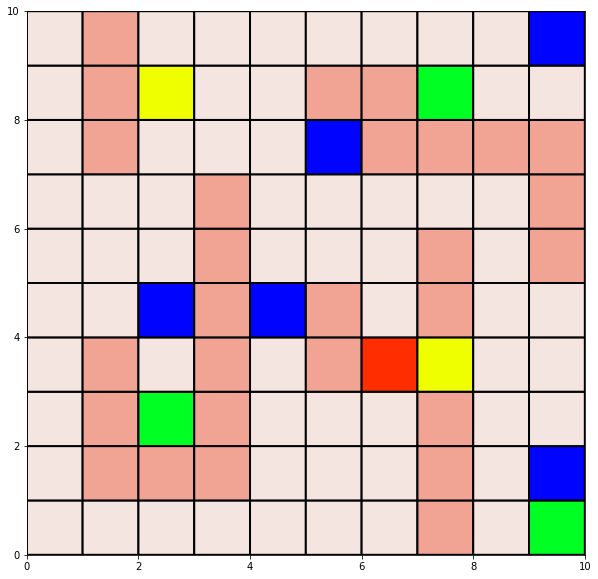

In [ ]:


num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-10)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()
plt.figure(figsize=(10, 10))
env.render(ax=plt, render_agent=False)

### Legend
- <span style="color:#F0FF00">*Light brown*</span> is **normal states of the agent**.
- <span style="color:#0004FF">*Red*</span> is the **start state**.
- <span style="color:#00FF23">*Green*</span> is the **goal state**.
- <span style="color:#F0FF00">*Dark brown*</span> is **obstructed states of the agent**.
- <span style="color:#F0FF00">*Blue*</span> is **bad states of the agent**.
- <span style="color:#F0FF00">*Yellow*</span> is **restart states of the agent**.



In [ ]:
def plot_Q(Q, message=None, save=False):
    
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [RIGHT, LEFT]:
            return 0
        return 1 if a == UP else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    print(save)
    if save:
        plt.savefig(fname = message, format = 'pdf')
    plt.show()

def plot_T(T, message=None, save=False):    
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(T, edgecolors='k', linewidths=2)
    plt.colorbar()
    if save:
        plt.savefig(fname = message, format = 'pdf')
    plt.show()



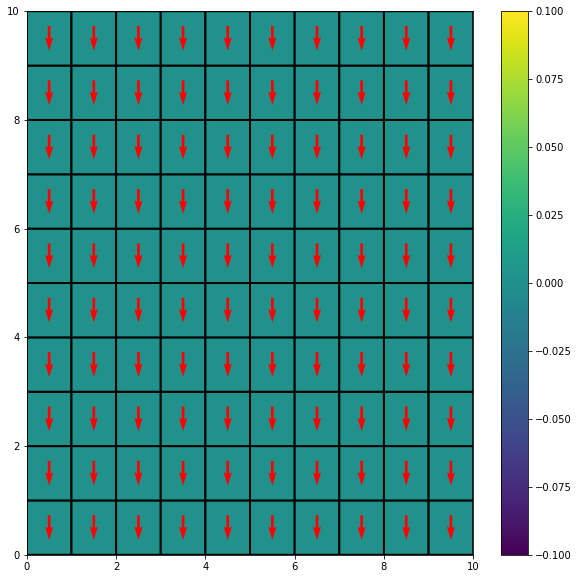

(10, 10, 4)

In [ ]:


Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))


plot_Q(Q, save=False)

Q.shape

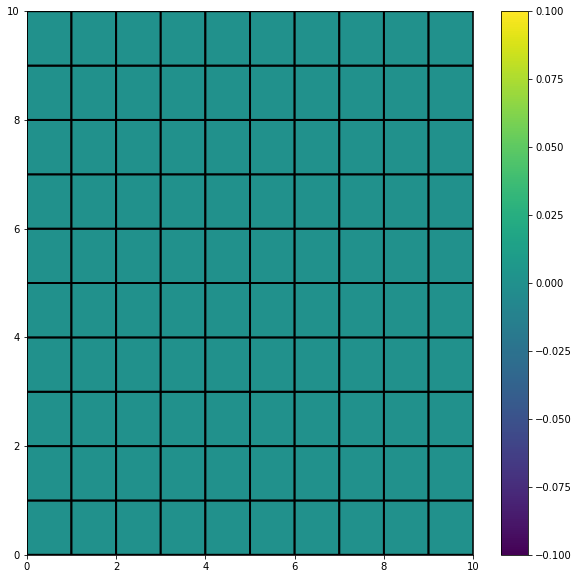

In [ ]:
T = np.zeros((env.num_rows, env.num_cols))
plot_T(T, save=False)

### Exploration strategies
1. Epsilon-greedy
2. Softmax

In [ ]:
from scipy.special import softmax

seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy
def choose_action_epsilon(Q, state, rg=rg, epsilon = 0.1, temperature = 1):
    if not Q[state[0], state[1]].any() or rg.rand() < epsilon:
        return rg.choice(Q.shape[-1])
    else:
        return np.argmax(Q[state[0], state[1]])

# Softmax
def choose_action_softmax(Q, state, rg=rg, epsilon = 0.1 , temperature = 1):
    return rg.choice(Q.shape[-1], p = softmax(Q[state[0], state[1]]/temperature))

## SARSA
Now we implement the SARSA algorithm.



In [ ]:
print_freq = 500
episodes = 5000

def sarsa(env, Q, T, epsilon=0.1, alpha=0.4, gamma=0.9, temperature = 1, plot_heat = False, choose_action = choose_action_softmax, episodes = 5000):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
        plot_T(T)
    epsilon = epsilon
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        row_col_state = seq_to_col_row(state)[0]
        action = choose_action(Q, row_col_state)
        done = False
        while not done:
            
            state_next, reward, done = env.step(state, action)
            row_col_state_next = seq_to_col_row(state_next)[0]
            action_next = choose_action(Q, row_col_state_next, epsilon = epsilon , temperature = temperature)
            
            # update equation
            Q[row_col_state[0], row_col_state[1], action] += alpha*(reward + gamma*Q[row_col_state_next[0], row_col_state_next[1], action_next] - Q[row_col_state[0], row_col_state[1], action])
            T[row_col_state[0], row_col_state[1]] += 1                                        
            tot_reward += reward
            steps += 1
            state, action = state_next, action_next
            row_col_state = seq_to_col_row(state)[0]
            if(steps > 10000):
                return Q, T, episode_rewards, steps_to_completion
        
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q = Q, message = "Sample Q plot", save = False)
            plot_T(T = T, message = "Sample T plot", save = False)
                
    return Q, T, episode_rewards, steps_to_completion

False


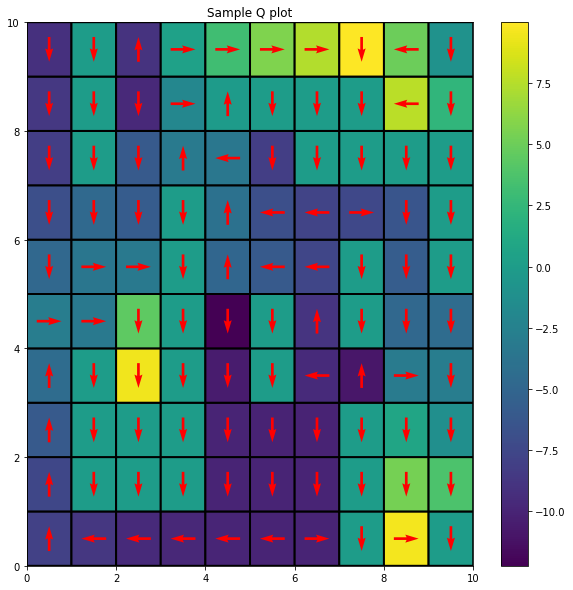

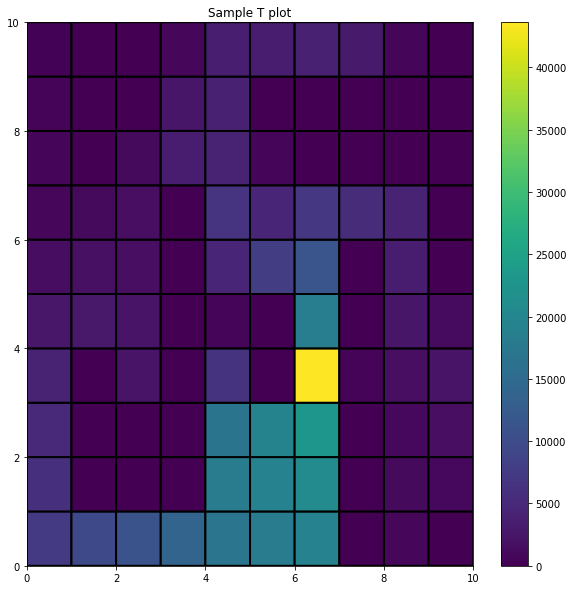

100%|██████████| 5000/5000 [02:12<00:00, 37.63it/s]


In [ ]:
Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
T = np.zeros((env.num_rows, env.num_cols))
#episodes = 10000
Q, T, rewards, steps = sarsa(env, Q, T, plot_heat=True, choose_action= choose_action_softmax)

### Visualizing the policy
Now let's see the agent in action.
Run the below cell (as many times) to render the policy;

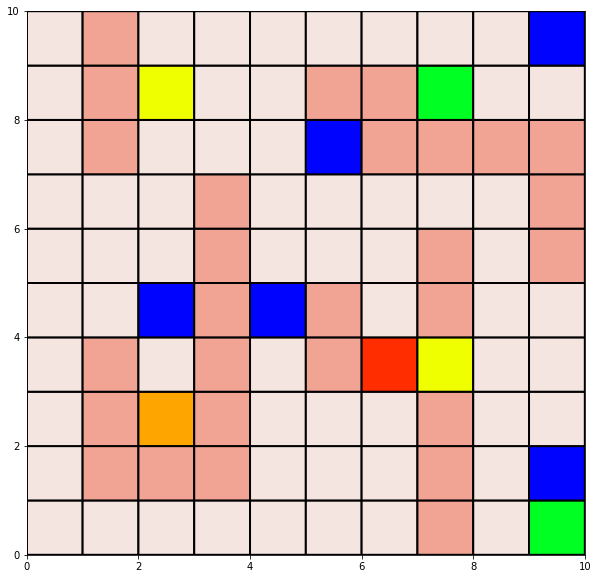

Steps: 25, Total Reward: -19


In [ ]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    row_col_state = seq_to_col_row(state)[0]
    state, reward, done = env.step(state, Q[row_col_state[0], row_col_state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, agent_state=state, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

### Analyzing performance of the policy
We use two metrics to analyze the:

1. Average steps to reach the goal
2. Total rewards from the episode

To ensure, we account for randomness in environment and algorithm (say when using epsilon-greedy exploration), we run the algorithm for multiple times and use the average of values over all runs.

In [ ]:
Q_avgs, reward_avgs, steps_avgs = [], [], []
num_expts = 1


for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
    T = np.zeros((env.num_rows, env.num_cols))
    rg = np.random.RandomState(i)
    Q, T, rewards, steps = sarsa(env, Q, T)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)

Experiment: 1


100%|██████████| 5000/5000 [02:00<00:00, 41.38it/s]


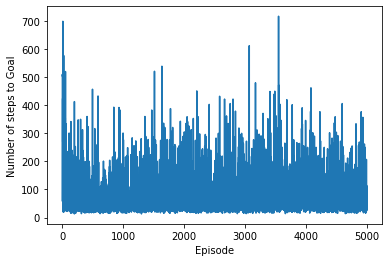

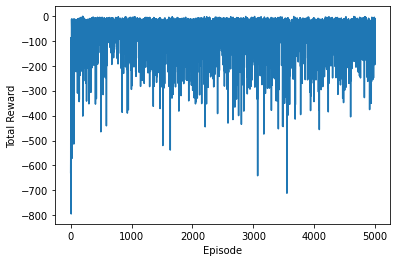

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

### Q-Learning
Now lets implement the Q-Learning algorithm 

In [ ]:
print_freq = 500
episodes = 5000
step_cnt = 0
def Q_Learning(env, Q, T, epsilon = 0.1, alpha = 0.4, gamma = 0.9, temperature = 1, plot_heat = False, choose_action = choose_action_softmax, episodes = 5000):
  episode_rewards = np.zeros(episodes)
  steps_to_completion = np.zeros(episodes)
  if plot_heat:
    clear_output(wait = True)
    plot_Q(Q)
    plot_T(T)
  #epsilon = epsilon0
  #alpha = alpha0

  for ep in tqdm(range(episodes)):
    tot_reward = 0
    steps = 0
    done = False

    state = env.reset()
    steps_cnt = 0
    while not done:
      steps_cnt = steps_cnt + 1
      state_row_col = seq_to_col_row(state)[0]
      action = choose_action(Q,state_row_col, epsilon = epsilon , temperature = temperature)
      state_next,reward,done = env.step(state, action)
      state_next_row_col = seq_to_col_row(state_next)[0]
      steps_cnt = steps_cnt + 1 
      
      
      #update equation
      v_pi_s = -np.inf
      for i in range(4):
        v_pi_s = max(v_pi_s,reward + gamma*(Q[state_next_row_col[0],state_next_row_col[1],i]))
      
      Q[state_row_col[0],state_row_col[1],action] += alpha*(v_pi_s - Q[state_row_col[0], state_row_col[1], action])
      T[state_row_col[0], state_row_col[1]] += 1
    
      tot_reward += reward
      steps += 1

      state = state_next
      if(steps_cnt > 10004):
        return Q, T, episode_rewards, steps_to_completion
    episode_rewards[ep] = tot_reward
    steps_to_completion[ep] = steps

    if (ep+1)%print_freq == 0 and plot_heat:
      clear_output(wait=True)
      plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
      plot_T(T, message = "Episode %d: Reward: %f, Steps: %.2f, Tmax: %.2f, Tmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           T.max(), T.min()))
            
  return Q, T, episode_rewards, steps_to_completion

False


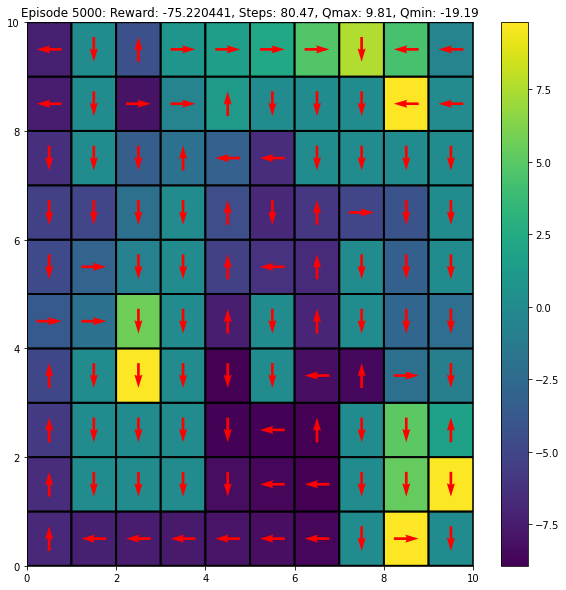

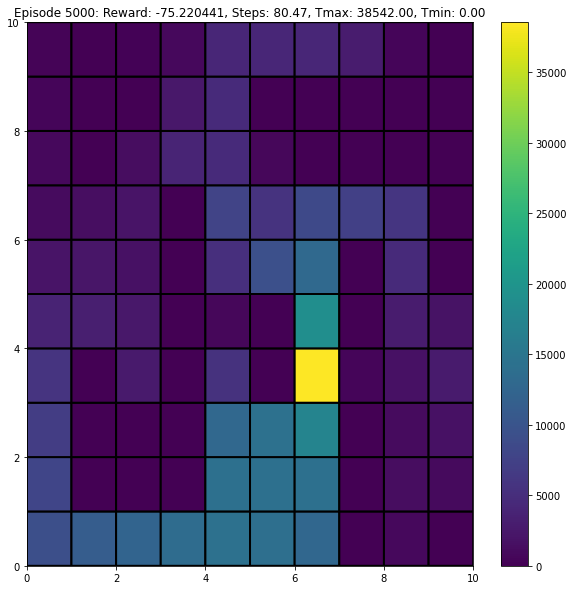

100%|██████████| 5000/5000 [02:13<00:00, 37.36it/s]


In [ ]:
Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
T = np.zeros((env.num_rows, env.num_cols))
episodes = 5000
Q, T, rewards, steps = Q_Learning(env, Q, T, plot_heat=True, choose_action= choose_action_softmax)

### Visualizing the policy
Now let's see the agent in action.
Run the below cell (as many times) to render the policy;

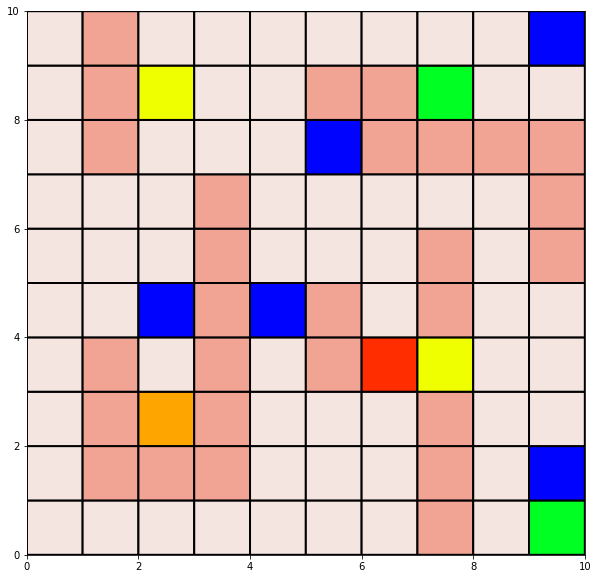

Steps: 28, Total Reward: -27


In [ ]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    row_col_state = seq_to_col_row(state)[0]
    state, reward, done = env.step(state, Q[row_col_state[0], row_col_state[1]].argmax())
    plt.figure(figsize=(10, 10))
    env.render(ax=plt, agent_state=state, render_agent=True)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

### Analyzing performance of the policy
We use two metrics to analyze:

1. Average steps to reach the goal
2. Total rewards from the episode

To ensure, we account for randomness in environment and algorithm (say when using epsilon-greedy exploration), we run the algorithm for multiple times and use the average of values over all runs.

In [ ]:
Q_avgs, reward_avgs, steps_avgs = [], [], []
num_expts = 5

for i in range(num_expts):
    print("Experiment: %d"%(i+1))
    Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
    rg = np.random.RandomState(i)
    Q, rewards, steps = sarsa(env, Q)
    Q_avgs.append(Q.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)

Experiment: 1


100%|██████████| 10000/10000 [02:38<00:00, 62.92it/s]


Experiment: 2


100%|██████████| 10000/10000 [02:41<00:00, 61.98it/s]


Experiment: 3


100%|██████████| 10000/10000 [02:55<00:00, 56.94it/s]


Experiment: 4


100%|██████████| 10000/10000 [02:52<00:00, 57.89it/s]


Experiment: 5


100%|██████████| 10000/10000 [02:40<00:00, 62.15it/s]


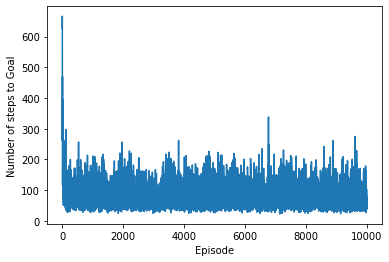

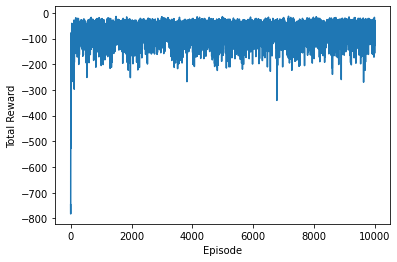

In [ ]:
plt.xlabel('Episode')
plt.ylabel('Number of steps to Goal')
plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
plt.show()
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
plt.show()

In [ ]:
def get_avg(env, algorithm, alpha = 0.4 , epsilon = 0.1 , gamma = 0.9, choose_action = choose_action_softmax, temperature = 1, episodes=5000):
  Q_avgs, T_avgs, reward_avgs, steps_avgs = [], [], [], []
  num_expts = 1

  for i in range(num_expts):
    #print("Experiment: %d"%(i+1))
    Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
    T = np.zeros((env.num_rows, env.num_cols))
    rg = np.random.RandomState(i)
    Q, T, rewards, steps = algorithm(env, Q, T, epsilon = epsilon, alpha = alpha, gamma = gamma, temperature = temperature, plot_heat = False, choose_action = choose_action, episodes=episodes)
    Q_avgs.append(Q.copy())
    T_avgs.append(T.copy())
    reward_avgs.append(rewards)
    steps_avgs.append(steps)

  return Q_avgs, T_avgs, reward_avgs , steps_avgs

### Hyperparameter Tuning

Now we plot the reward curves and step curves while varying a single hyperparameter to get the best value. 3 plots (each having 4 possible values of a hyperparameter) are plotted for each of the 16 configurations under each algorihm (Q-learning / Sarsa)

Total number of plots  = 3 x 16 x 2 x 2

These plots for Q-Learning are available here =>  https://drive.google.com/drive/folders/1OCsHMIBsTSMZhXsATauXm_YxdpgkdpMc?usp=sharing

And those for Sarsa are available here => https://drive.google.com/drive/folders/1AKkHsuAaeMEuRrNOpUuAOAA36SKIj4tZ


In [ ]:
# run this cell to make all the plots with variations of hyperplots (3 plots showing variation of 3 parameters (for 4 values each) for each configuration )
import string
num_cols = 10
num_rows = 10
epsiodes = 10000
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                        [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                        [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                        [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
goal_states = np.array([[0,9],[2,2],[8,7]])
for wind in [True]:
    for start_state in [np.array([[3, 6]])]:
        for p in [1.0, 0.7]:
            gw = GridWorld(num_rows=num_rows,
                        num_cols=num_cols,
                        start_state=start_state,
                        goal_states=goal_states, wind = wind)
            gw.add_obstructions(obstructed_states=obstructions,
                                bad_states=bad_states,
                                restart_states=restart_states)
            gw.add_rewards(step_reward=-1,
                        goal_reward=10,
                        bad_state_reward=-6,
                        restart_state_reward=-100)
            gw.add_transition_probability(p_good_transition=p,
                                        bias=0.5)
            
            env = gw.create_gridworld()
            for algorithm in [Q_Learning]:                                                                 
                for choose_action in [choose_action_softmax, choose_action_epsilon]:
                    action_category = 'softmax'
                    if(choose_action == choose_action_epsilon):
                      action_category = 'epsilon-greedy'
                    algo = 'Sarsa'
                    if(algorithm == Q_Learning): algo = 'Q_Learning'

                    if(choose_action != choose_action_softmax):
                      epsilons = [0.01, 0.05, 0.1, 0.2]
                      #print('lala')
                    
                    
                      step_graph = []
                      plt.figure(figsize = (10,16))
        
                      fig,axs = plt.subplots(2,2)
                      cnt = 0
                      for epsilon in epsilons:
                    
                        Q_avgs, T_avgs, reward_avgs, steps_avgs = get_avg(env, algorithm, alpha = 0.2, epsilon = epsilon , gamma = 0.9, choose_action = choose_action, temperature = 1)
                        step_graph.append(steps_avgs)
                        axs[(cnt//2),(cnt%2)].plot(np.arange(episodes),np.average(reward_avgs,0))
                        axs[(cnt//2),(cnt%2)].set_title('\u03B5 = {}'.format(epsilon))
                        cnt = cnt + 1
                      name1 = ('start_state = {}  Wind = {}  p = {}  algorithm = {}  action = {}  \u03B3 = {}  \u03B1 = {}  \u03F4 = {}'.format(str(start_state), str(wind), str(p) , algo , action_category,
                              str(0.9), str(0.4), str(1)))
                      fig.suptitle(name1)
                      for ax in axs.flat:      
                        ax.set(xlabel = 'Episodes')
                        ax.set(ylabel = 'Total Reward') 

                      for ax in axs.flat:
                        ax.label_outer()           
                    
                      #print(name1)
                      #print(type(name1))
                    
                      plt.savefig(fname = name1,format = 'jpeg')
                      plt.show()
                    
                      plt.figure(figsize = (10,16))
                      fig,axs = plt.subplots(2,2)
                      cnt = 0
                      for steps_avgs in step_graph:
                  
                        axs[(cnt//2),(cnt%2)].plot(np.arange(episodes),np.average(steps_avgs,0))
                        axs[(cnt//2),(cnt%2)].set_title('\u03B5 = {}'.format(epsilons[cnt]))
                        cnt = cnt + 1
                      name1 = ('start_state = {}  Wind = {}  p = {}  algorithm = {}  action = {}  \u03B3 = {}  \u03B1 = {}  \u03F4 = {}'.format(str(start_state), str(wind), str(p) , algo , action_category,
                              str(0.9), str(0.4), str(1)))
                      fig.suptitle(name1)
                      for ax in axs.flat:      
                        ax.set(xlabel = 'Episodes')
                        ax.set(ylabel = 'Number of Steps') 
                      for ax in axs.flat:
                        ax.label_outer() 

                    
                      plt.savefig(fname = name1+"*",format = 'jpeg')
                      plt.show()
                    


                    alphas = [0.01, 0.1 , 0.2, 0.5]
                    plt.figure(figsize = (10,16))
                    fig,axs = plt.subplots(2,2)
                    step_graph = []
                    cnt = 0
                    for alpha in alphas:
                      Q_avgs, T_avgs, reward_avgs, steps_avgs = get_avg(env, algorithm, alpha = alpha, epsilon = 0.1 , gamma = 0.9, choose_action = choose_action, temperature = 1)
                      step_graph.append(steps_avgs)
                      axs[(cnt//2),(cnt%2)].plot(np.arange(episodes),np.average(reward_avgs,0))
                      axs[(cnt//2),(cnt%2)].set_title('\u03B1 = {}'.format(alpha))
                      cnt = cnt + 1
                    name1 = ('start_state = {}  Wind = {}  p = {}  algorithm = {}  action = {}  epsilon = {}  \u03B3 = {}  \u03F4 = {}'.format(str(start_state), str(wind), str(p) , algo , action_category,
                              str(0.1), str(0.9), str(1)))
                    fig.suptitle(name1)
                    for ax in axs.flat:      
                      ax.set(xlabel = 'Episodes')
                      ax.set(ylabel = 'Total Reward') 
                    for ax in axs.flat:
                      ax.label_outer()
                    
                    plt.savefig(fname = name1,format = 'jpeg')
                    plt.show()
                    
                    
                    
                    cnt = 0
                    plt.figure(figsize = (10,16))
                    fig,axs = plt.subplots(2,2)
                    for steps_avgs in step_graph:

                      axs[(cnt//2),(cnt%2)].plot(np.arange(episodes),np.average(steps_avgs,0))
                      axs[(cnt//2),(cnt%2)].set_title('\u03B1 = {}'.format(alphas[cnt]))
                      cnt = cnt + 1

                    for ax in axs.flat:      
                      ax.set(xlabel = 'Episodes')
                      ax.set(ylabel = 'Number of Steps')
                    for ax in axs.flat:
                      ax.label_outer()
                    name1 = ('start_state = {}  Wind = {}  p = {}  algorithm = {}  action = {}  epsilon = {}  \u03B3 = {}  \u03F4 = {}'.format(str(start_state), str(wind), str(p) , algo , action_category,
                              str(0.1), str(0.9), str(1)))
                    fig.suptitle(name1)
                    
                    plt.savefig(fname = name1+"*",format = 'jpeg')
                    plt.show()
                    

                    gammas = [0.1,0.5, 0.9, 0.99]
                    
                    
                    step_graph = []
                    cnt = 0
                    plt.figure(figsize = (10,16))
                    fig,axs = plt.subplots(2,2)
                    for gamma in gammas:
                      Q_avgs, T_avgs, reward_avgs, steps_avgs = get_avg(env, algorithm, alpha = 0.4, epsilon = 0.1 , gamma = gamma, choose_action = choose_action, temperature = 1)
                      step_graph.append(steps_avgs)
                      axs[(cnt//2),(cnt%2)].plot(np.arange(episodes),np.average(reward_avgs,0))
                      axs[(cnt//2),(cnt%2)].set_title('\u03B3 = {}'.format(gamma))
                      cnt = cnt + 1
                    name1 = ('start_state = {}  Wind = {}  p = {}  algorithm = {}  action = {}  epsilon = {}  \u03B1 = {}  \u03F4 = {}'.format(str(start_state), str(wind), str(p) , algo , action_category,
                              str(0.1), str(0.4), str(1)))
                    fig.suptitle(name1)
                    for ax in axs.flat:      
                      ax.set(xlabel = 'Episodes')
                      ax.set(ylabel = 'Rewards')
                    for ax in axs.flat:
                      ax.label_outer()
                   
                    plt.savefig(fname = name1,format = 'jpeg')
                    plt.show()
                    
                    
                    cnt = 0
                    plt.figure(figsize = (10,16))
                    fig,axs = plt.subplots(2,2)
                    for steps_avgs in step_graph:
                      axs[(cnt//2),(cnt%2)].plot(np.arange(episodes),np.average(steps_avgs,0))
                      axs[(cnt//2),(cnt%2)].set_title('\u03B3 = {}'.format(gammas[cnt]))
                      cnt = cnt + 1
                    name1 = ('start_state = {}  Wind = {}  p = {}  algorithm = {}  action = {}  epsilon = {}  \u03B1 = {}  \u03F4 = {}'.format(str(start_state), str(wind), str(p) , algo , action_category,
                              str(0.1), str(0.4), str(1)))
                    fig.suptitle(name1)
                    for ax in axs.flat:      
                      ax.set(xlabel = 'Episodes')
                      ax.set(ylabel = 'Number of Steps')
                    for ax in axs.flat:
                      ax.label_outer()
                    
                    plt.savefig(fname = name1+"*",format = 'pdf')
                    plt.show()
                    
                      
                    if(choose_action == choose_action_epsilon):
                      continue
                    temperatures = [0.5 ,1, 1.5,5]

                    
                    cnt = 0
                    plt.figure(figsize = (10,16))
                    fig,axs = plt.subplots(2,2)
                    step_graph = []
                    for temperature in temperatures:
                      Q_avgs, T_avgs, reward_avgs, steps_avgs = get_avg(env, algorithm, alpha = 0.4, epsilon = 0.1 , choose_action = choose_action, temperature = temperature)
                      step_graph.append(steps_avgs)
                      axs[(cnt//2),(cnt%2)].plot(np.arange(episodes),np.average(reward_avgs,0),)
                      axs[(cnt//2),(cnt%2)].set_title('\u03F4 = {}'.format(temperature))
                      cnt = cnt + 1
                    name1 = ('start_state = {}  Wind = {}  p = {}  algorithm = {}  action = {}  epsilon = {}  \u03B3 = {}  \u03B1 = {}'.format(str(start_state), str(wind), str(p) , algo , action_category,
                              str(0.1), str(0.9), str(0.4)))
                    fig.suptitle(name1)
                    for ax in axs.flat:      
                      ax.set(xlabel = 'Episodes')
                      ax.set(ylabel = 'Rewards')
                    for ax in axs.flat:
                      ax.label_outer()
                    plt.savefig(fname = name1,format = 'pdf')
                    plt.show()
                    
                    
                    cnt = 0
                    plt.figure(figsize = (10,16))
                    fig,axs = plt.subplots(2,2)
                    for steps_avgs in step_graph:
                      axs[(cnt//2),(cnt%2)].plot(np.arange(episodes),np.average(steps_avgs,0))
                      axs[(cnt//2),(cnt%2)].set_title('\u03F4 = {}'.format(temperatures[cnt]))
                      cnt = cnt + 1
                    name1 = ('start_state = {}  Wind = {}  p = {}  algorithm = {}  action = {}  epsilon = {}  \u03B3 = {}  \u03B1 = {}'.format(str(start_state), str(wind), str(p) , algo , action_category,
                              str(0.1), str(0.9), str(0.4)))
                    fig.suptitle(name1)
                    for ax in axs.flat:      
                      ax.set(xlabel = 'Episodes')
                      ax.set(ylabel = 'Number of Steps')
                    for ax in axs.flat:
                      ax.label_outer()
                    plt.savefig(fname = name1+"*",format = 'pdf')
                    plt.show()
                    
                    
                      
                      
                   

### Best plots

In [ ]:
def plot_reward(reward_avgs, message):
  plt.title(message)
  plt.xlabel('Episode')
  plt.ylabel('Total Reward')
  plt.plot(np.arange(episodes),np.average(reward_avgs, 0))
  plt.savefig(fname = message, format = 'pdf')
  plt.show()

def plot_steps(steps_avgs,message):
  plt.title(message)
  plt.xlabel('Episode')
  plt.ylabel('Number of steps to Goal')
  plt.plot(np.arange(episodes),np.average(steps_avgs, 0))
  plt.savefig(fname = message, format = 'pdf')
  plt.show()

  

After analyzing the above rendered plots, we plot the best plots for each configuration with the best possible value of the hyperparameters

Number of plots = 4 (2 heat maps, reward, step curves) x 16 x 2 (Q-Learning /Sarsa)

In [ ]:
#Best plots:
#run this cell to generate best plots (4 plots(2 heatmaps, rewards curve and step curve) X 16 configurations X 2 Algorithms (Q-Learning and Sarsa))


num_cols = 10
episodes = 5000
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                        [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                        [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                        [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
goal_states = np.array([[0,9],[2,2],[8,7]])
config = 0
for wind in [False, True]:
    for start_state in [np.array([[0, 4]]), np.array([[3, 6]])]:
        for p in [1.0, 0.7]:
            gw = GridWorld(num_rows=num_rows,
                        num_cols=num_cols,
                        start_state=start_state,
                        goal_states=goal_states, wind = wind)
            gw.add_obstructions(obstructed_states=obstructions,
                                bad_states=bad_states,
                                restart_states=restart_states)
            gw.add_rewards(step_reward=-1,
                        goal_reward=10,
                        bad_state_reward=-6,
                        restart_state_reward=-100)
            gw.add_transition_probability(p_good_transition=p,
                                        bias=0.5)
            
            env = gw.create_gridworld()
                                                                            
            for choose_action in [choose_action_epsilon, choose_action_softmax]:

                for algorithm in [Q_Learning,sarsa]: 
                    
                    
                    if config is 0:
                      if(algorithm == sarsa):
                        [epsilon, alpha, gamma, temp] = [0.2, 0.2, 0.9, 1]
                      else:
                        [epsilon, alpha, gamma, temp] = [0.2, 0.2, 0.99, 1]

                    elif config is 1:
                      if(algorithm == sarsa):
                        [epsilon, alpha, gamma, temp] = [1, 0.5, 0.99, 1]
                      else:
                        [epsilon, alpha, gamma, temp] = [0.1, 0.2, 0.99, 1.5]

                    elif config is 2:
                      if(algorithm == sarsa):
                        [epsilon, alpha, gamma, temp] = [0.01, 0.2, 0.99, 1]
                      else:
                        [epsilon, alpha, gamma, temp] = [0.1, 0.2, 0.9, 1]

                    elif config is 3:
                      if(algorithm == sarsa):
                        [epsilon, alpha, gamma, temp] = [1, 0.2, 0.9, 0.5]
                      else:
                        [epsilon, alpha, gamma, temp] = [1, 0.2, 0.99, 1.5]

                    elif config is 4:
                      if(algorithm == sarsa):
                        [epsilon, alpha, gamma, temp] = [0.2, 0.5, 0.9, 1]
                      else:
                        [epsilon, alpha, gamma, temp] = [0.1, 0.5, 0.99, 1]

                    elif config is 5:
                      if(algorithm == sarsa):
                        [epsilon, alpha, gamma, temp] = [1, 0.2, 0.9, 1.5]
                      else:
                        [epsilon, alpha, gamma, temp] = [1, 0.5, 0.99, 1.5]

                    elif config is 6:
                      if(algorithm == sarsa):
                        [epsilon, alpha, gamma, temp] = [0.05, 0.1, 0.99, 1]
                      else:
                        [epsilon, alpha, gamma, temp] = [0.1, 0.2, 0.9, 1]

                    elif config is 7:
                      if(algorithm == sarsa):
                        [epsilon, alpha, gamma, temp] = [1, 0.2, 0.9, 1]
                      else:
                        [epsilon, alpha, gamma, temp] = [1, 0.1, 0.99, 1]

                    elif config is 8:
                      if(algorithm == sarsa):
                        [epsilon, alpha, gamma, temp] = [0.2, 0.5, 0.9, 1]
                      else:
                        [epsilon, alpha, gamma, temp] = [0.05, 0.5, 0.99, 1]


                    elif config is 9:
                      if(algorithm == sarsa):
                        [epsilon, alpha, gamma, temp] = [1, 0.01, 0.99, 0.5]
                      else:
                        [epsilon, alpha, gamma, temp] = [1, 0.01, 0.99, 0.5]

                    elif config is 10:
                      if(algorithm == sarsa):
                        [epsilon, alpha, gamma, temp] = [0.1, 0.1, 0.99, 1]
                      else:
                        [epsilon, alpha, gamma, temp] = [0.05, 0.2, 0.9, 1]
                    
                    
                    elif config is 11:
                      if(algorithm == sarsa):
                        [epsilon, alpha, gamma, temp] = [1, 0.2, 0.99, 5]
                      else:
                        [epsilon, alpha, gamma, temp] = [1, 0.01, 0.99, 5]
                  
                    elif config is 12:
                      if(algorithm == sarsa):
                        [epsilon, alpha, gamma, temp] = [0.05, 0.5, 0.9, 1]
                      else:
                        [epsilon, alpha, gamma, temp] = [0.1, 0.2, 0.9, 1]


                    elif config is 13:
                      if(algorithm == sarsa):
                        [epsilon, alpha, gamma, temp] = [1, 0.01, 0.99, 0.5]
                      else:
                        [epsilon, alpha, gamma, temp] = [1, 0.5, 0.9, 0.5]


                    elif config is 14:
                      if(algorithm == sarsa):
                        [epsilon, alpha, gamma, temp] = [0.1, 0.2, 0.9, 1]
                      else:
                        [epsilon, alpha, gamma, temp] = [0.2, 0.2, 0.9, 1]


                    elif config is 15:
                      if(algorithm == sarsa):
                        [epsilon, alpha, gamma, temp] = [1, 0.01, 0.99, 5]
                      else:
                        [epsilon, alpha, gamma, temp] = [1, 0.5, 0.99, 1]
                    
                    Q_avgs, T_avgs, reward_avgs, steps_avgs = get_avg(env, algorithm, alpha = alpha, epsilon = epsilon , gamma = gamma, choose_action = choose_action, temperature = temp, episodes=episodes)
                    
                    #fig,axs = plt.subplots(2,2)
                    Q_avgs = Q_avgs[0]
                    T_avgs = T_avgs[0]
                    #print(T_avgs)
                    algoname = 'Q_Learning'
                    if(algorithm == sarsa):
                      algoname = 'Sarsa'

                    plot_Q(Q_avgs, "Q_Plot Configuration = {}  Algorithm = {}".format(str(config), str(algoname)))
                    plot_T(T_avgs,"T_Plot Configuration = {}  Algorithm = {}".format(str(config), str(algoname)))
                    plot_reward(reward_avgs,"Rewards_Plot Configuration = {}  Algorithm = {}".format(str(config), str(algoname)))
                    plot_steps(steps_avgs,"Steps_Plot Configuration = {}  Algorithm = {}".format(str(config), str(algoname)))

                config += 1
                    
                 







Best plots can be found in the report or https://drive.google.com/drive/folders/1AKkHsuAaeMEuRrNOpUuAOAA36SKIj4tZ